# Vehicle Routing Problem

In [1]:
import numpy as np
#np.set_printoptions(threshold=np.nan)
import seaborn as sns
from matplotlib import pyplot as plt
import math
import copy
import random
import timeit
from scipy.spatial import distance
import operator
import sys
#from google.colab import files
#uploaded = files.upload()

## 1. Import, Data Investigation and Preprocessing

Import

In [2]:
# VRP1
# import distance matrix
filepath = 'VRP1/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix.append(y)
        
    t.close()
    distance_matrix = np.array(distance_matrix)

# import demand matrix
filepath = 'VRP1/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix.append(y)
        
    t.close()
    demand_matrix = np.array(demand_matrix)
    demand_matrix = demand_matrix[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix = np.insert(demand_matrix,0,0)

# import capacity matrix
filepath = 'VRP1/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix.append(y)
        
    t.close()
    capacity_matrix = np.array(capacity_matrix)
    capacity_matrix = capacity_matrix[0]

# import transportation_cost matrix
filepath = 'VRP1/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost.append(y)
        
    t.close()
    transportation_cost = np.array(transportation_cost)
    transportation_cost = transportation_cost[0]
# VRP2
# import distance matrix
filepath = 'VRP2/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix_2.append(y)
        
    t.close()
    distance_matrix_2 = np.array(distance_matrix_2)

# import demand matrix
filepath = 'VRP2/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix_2.append(y)
        
    t.close()
    demand_matrix_2 = np.array(demand_matrix)
    demand_matrix_2 = demand_matrix_2[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix_2 = np.insert(demand_matrix,0,0)

    
# import capacity matrix
filepath = 'VRP2/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix_2.append(y)
        
    t.close()
    capacity_matrix_2 = np.array(capacity_matrix_2)
    capacity_matrix_2 = capacity_matrix_2[0]
    

    
# import transportation_cost matrix
filepath = 'VRP2/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost_2.append(y)
        
    t.close()
    transportation_cost_2 = np.array(transportation_cost_2)
    transportation_cost_2 = transportation_cost_2[0]

In [3]:
# which data to use
#demand_matrix = demand_matrix_2

Data Investigation

In [4]:
# information about the distance matrix for VRP1
print("Information about distance matric for VRP1 \n# columns: ", len(distance_matrix[0]))
print("# lines: ", len(distance_matrix))
asymmetric = (distance_matrix != np.transpose(distance_matrix))
print(np.unique(asymmetric))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. \n")

# information about the distance matrix for VRP2
print("Information about distance matric for VRP2 \n# columns: ", len(distance_matrix_2[0]))
print("# lines: ", len(distance_matrix_2))
asymmetric_2 = (distance_matrix_2 != np.transpose(distance_matrix_2))
                
print(np.unique(asymmetric_2))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.")

Information about distance matric for VRP1 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. 

Information about distance matric for VRP2 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.


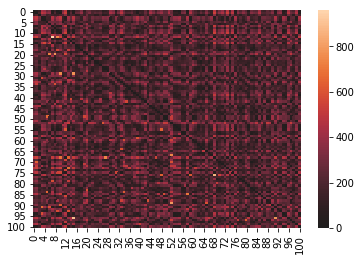

In [5]:
#heatmap
ax = sns.heatmap(distance_matrix, center=0)

The heatmap again illustrates the fact that we have to deal with an asymmetric distance matrix. In order to apply the k-means algorithm, we need a symmetric matrix. Therefore we need to make our distances symmetric be taking the mean between the distances (if they are different).

In [6]:
capacity_matrix_2

array([ 100,  100,  100,  100,  100,  100,  100,  100,  100,  100,  100,
        100,  100,  100,  100,  100,  100,  100,  100,  100,  300,  300,
        300,  300,  300,  300,  300,  500,  500,  500,  500, 1000, 1000])

In [7]:
capacity_matrix

array([ 100,  100,  100,  100,  100,  100,  100,  100,  100,  100,  100,
        100,  100,  100,  100,  100,  100,  100,  100,  100,  300,  300,
        300,  300,  300,  300,  300,  500,  500,  500,  500, 1000, 1000])

## 2. Clustering

In [8]:
def average_dist(cluster):
    
    sum_distance = 0
    avg_distance = 0
    
    # from every node to every node in the current cluster calculate the overall distance
    for node1 in cluster:
        for node2 in cluster:
            sum_distance += distance_matrix[node1][node2]

    # and calculate the average as an approximation
    one_edge = sum_distance/(len(cluster)**2-2)
    avg_distance = one_edge * (len(cluster)-1)
    
    return avg_distance

In [9]:
def total_demand_satisfied(route):
    total_demand_satisfied = 0
    for i in route:
        total_demand_satisfied += demand_matrix[i]
    return total_demand_satisfied

In [10]:
def total_cars():
    '''
    returns the sorted sets of capacities available with their according costs and those zipped information as dict
    '''
    unique_capacity = sorted(set(capacity_matrix)) #VRP1: 100, 300, 500, 1000
    unique_cost = sorted(set(transportation_cost)) #VRP1: 11, 13, 15, 18
    
    cap = capacity_matrix
    num_cars = [list(cap).count(value) for value in unique_capacity]
    total_cars = dict(zip(unique_capacity, num_cars))
    
    return unique_capacity, unique_cost, total_cars

In [11]:
def get_cost_list(cars_of_clusters):
    
    '''
    gives us the list of the costs of the cars of the final clusters
    '''
    
    cars_capacity = []
    cars_capacity = list(cars_of_clusters.values())
    
    unique_capacity = total_cars()[0]
    unique_cost = total_cars()[1]
    cost_list = []
    
    for i in range(len(cars_capacity)):
        for j in range(len(unique_capacity)):
            if cars_capacity[i] == unique_capacity[j]:
                cost_list.append(unique_cost[j])
    
    
    
    return cost_list
    
    

In [12]:
def optimal_car(single_cluster):
    '''
    check the output of the function with
        if type(x) == str:
    if it's True, then there is no car available for this cluster
    '''
    global cars_left
    
    unique_capacity, unique_cost, _ = total_cars()
    
    copy_cars_left = cars_left
    cars_possible = []
    cars_available = []
    
    for value in range(len(unique_capacity)):
        if total_demand_satisfied(single_cluster) < unique_capacity[value]:
            cars_possible.append(unique_capacity[value])
    
    cars_possible = sorted(cars_possible)
    cars_available = cars_possible[:]
    
    for car in cars_possible:
        test_value = copy_cars_left[car] - 1
        if test_value < 0:
            cars_available.remove(car)
            
    try:
        optimal_car = min(cars_available)
        return optimal_car
        
    except ValueError:
        return "no car available"

In [13]:
def update_cars_left(string, used_car):
    '''
    takes as input the chosen car and removes it from the global variable cars_left
    '''
    global cars_left
    
    if string == "+":
        cars_left[used_car] += 1
    if string == "-":
        cars_left[used_car] -= 1

In [14]:
def cluster_initialization():

    global cars_left
    global cars_used
    
    list_of_clusters = []
    customers = list(range(len(demand_matrix))[1:-1])
    visited_customers = []
    remaining_distance_matrix = copy.deepcopy(distance_matrix[0])

    while len(visited_customers) < len(customers)-1: 
        cluster = []
        demand = 0

        #add customers with smallest demand/distance ratio to cluster as long as overall demand of cluster is <= 100
        while total_demand_satisfied(cluster) < min(capacity_matrix):
            best_demand_distance_ratio = 0
            
            if cluster == []:
                #add depot, because that's where we are starting
                cluster.append(0)
                #choose customer furthest away from depot to create cluster
                while(cluster == [0]):
                    if visited_customers == []:
                        pass
                    else:
                        for values in visited_customers:
                            remaining_distance_matrix[values] = 0
                    first_customer = np.argmax(remaining_distance_matrix)
                    #add the best fitting customer to the cluster 
                    if first_customer not in visited_customers:
                        visited_customers.append(first_customer)
                        cluster.append(first_customer)

            else:
                #go through all customers
                for i in range(len(customers)):

                    #if customer is not added yet
                    if customers[i] not in visited_customers:
                        
                        #create a hypothetical cluster with the regarded customer and check the resulting demand-distance-ratio
                        cluster_copy = cluster[:]
                        cluster_copy.append(customers[i])
                        cluster_copy.append(0)

                        #calculate the demand_distance_ratio for comparison
                        demand_distance_ratio = total_demand_satisfied(cluster_copy) / average_dist(cluster_copy)

                        #find best customer
                        if demand_distance_ratio > best_demand_distance_ratio and total_demand_satisfied(cluster_copy) <= min(capacity_matrix):
                            best_demand_distance_ratio = demand_distance_ratio
                            best_customer = customers[i]

                if best_customer in visited_customers:
                    break
                #add the best fitting customer to the cluster
                else:
                    cluster.append(best_customer)
                    visited_customers.append(best_customer)
        cluster.append(0)
        update_cars_left("-", min(capacity_matrix))
        
        cars_used[str(cluster)] = min(capacity_matrix)
        
        list_of_clusters.append(cluster)
        
    return np.asarray([np.array(clusters) for clusters in list_of_clusters])

In [15]:
# has only one cluster as input
def demand_cost_ratio(cluster, capacity):
    #RETURN INDEX NOT VALUE
    #when using, cast the yield into a list and get max --> max(list(yield))
    cluster = list(cluster)
    unique_capacity = sorted(set(capacity_matrix))
    unique_cost = sorted(set(transportation_cost))

    capacity_dict = dict(zip(unique_capacity, unique_cost))
    cost = capacity_dict.get(capacity)

    
    demand_cost_ratio = total_demand_satisfied(cluster)/(average_dist(cluster) * cost) 
    
    return demand_cost_ratio

In [16]:
def evaluate_solution(list_of_clusters):
    
    global cars_used
    total_cost = 0
   
    unique_capacity, unique_cost, _ = total_cars()
    
    cost_dict = dict(zip(unique_capacity, unique_cost))
    sum_distance = 0
    
    for cluster in list_of_clusters:
        capacity = cars_used.get(str(cluster))
        cost = cost_dict.get(capacity)
        sum_distance = average_dist(cluster)
        
#         for node in range(len(cluster)-1):
#             sum_distance += distance_matrix[node][node+1]
        
        total_cost += (cost*sum_distance)
        
    return total_cost

In [17]:
def cost(cluster):
    
    cost = 0
    total_cost = 0
    
    unique_capacity, unique_cost, _ = total_cars()
    cost_dict = dict(zip(unique_capacity, unique_cost))
    
    capacity = cars_used.get(str(cluster))
    if capacity == None:
        capacity = optimal_car(cluster)
        
#     print("cluster", cluster)
#     print("capacity", capacity)
#     print("cars_used", cars_used)
    cost = cost_dict.get(capacity)
#     print("cost_dict",cost_dict)
    sum_distance = average_dist(cluster)
    
#     print("cost", cost)
#     print("sum_distance", sum_distance)
    total_cost = cost*sum_distance
    
    
    return total_cost

In [18]:
def merge(initial_clusters):
    
    '''
    returns the merged clusters 
    '''
    
    global cars_used
    
    initial_cost_ratio = []
    
    for cluster in initial_clusters:
        initial_cost_ratio.append(demand_cost_ratio(cluster, optimal_car(cluster)))
        
    solution = [list(value) for value in initial_clusters]
    
    #sort clusters according to demand/ cost ratio
    cluster_and_cost_dict = dict( zip(initial_cost_ratio, solution))
    sorted_cluster_and_cost_dict = sorted(cluster_and_cost_dict.items(), key = lambda s: s[0])
    
    #first approach was to only consider the 50% worst initial clusters
    #but yields worse results; if you want to try this also uncomment the join with the other 50% before the return
    #this variable mainly tells how around many 100 capacity cars are kept(i.e not selected for the merge in this iteration)
    #split_point = math.floor(len(sorted_cluster_and_cost_dict)/2)
    
    # consindering all initial clusters   
    clusters_to_be_merged = []
    for i in range(len(solution)):
        clusters_to_be_merged.append(sorted_cluster_and_cost_dict[i][1])
    
    
    copy_clusters_to_be_merged = clusters_to_be_merged[:]
    #print(copy_clusters_to_be_merged)
    start_cluster = []
    next_cluster = []
    new_cluster = []
    merged_clusters = []
    new_solution = []

    i = 0
    j = 0
        
    len_initial_cluster = len(clusters_to_be_merged)
    
    while j < len_initial_cluster:
        start_cluster = clusters_to_be_merged[j]
        i = j
    
        while i < len_initial_cluster-1:
            next_cluster = clusters_to_be_merged[i+1]
            merged_clusters = start_cluster[:-1] + next_cluster[1:]

            if new_solution == []: 
                new_solution.append(start_cluster)
            if all([next_cluster not in new_solution]): 
                new_solution.append(next_cluster)
            
            # from the global variable cars_used
            start_car = cars_used.get(str(start_cluster))
            next_car = cars_used.get(str(next_cluster))
            
            # checks if the optimal car for this cluster is available (if not, then merging is not possible)
            if optimal_car(merged_clusters) == "no car available":
                break
            else:
                merged_car = optimal_car(merged_clusters)

            # that was a different approach, substituting the demand_cost_ratio and using only cost() in the next if-statement
            #cost_factor_ratio = ((start_car + next_car)/merged_car)
            
            #print("start_car:", start_car)
            #print("next_car:", next_car)
            #print("merged_cluster", total_demand_satisfied(merged_clusters))
            #print("merged_car", merged_car)           

            #if the merged_cluster has a better demand_cost_ratio, merge
            if (demand_cost_ratio(start_cluster, start_car)) <= (demand_cost_ratio(merged_clusters, merged_car)):
            
            #different if statement that considers only cost not; unfortunately: IT'S NOT MERGING
            #if (cost(start_cluster)) >= (cost(merged_clusters)):
                
                index = new_solution.index(start_cluster)
                new_solution[index] = merged_clusters[:]
                new_solution.remove(next_cluster)

                del cars_used[str(start_cluster)]
                start_cluster = merged_clusters[:]

                len_initial_cluster = len_initial_cluster - 1
                
                # This is an annoying case. Happens when new_solution's last element is the merged cluster(else statement are the usual steps while if and elif take care of the boundary cases)   
                if len(new_solution) == 1:
                    clusters_to_be_merged = new_solution[:] + clusters_to_be_merged[1:]
                elif new_solution[-1] not in clusters_to_be_merged:
                    index_end = clusters_to_be_merged.index(new_solution[-2])
                    clusters_to_be_merged = new_solution[:] + clusters_to_be_merged[index_end+2:]
                else:
                    index_end = clusters_to_be_merged.index(new_solution[-1])
                    clusters_to_be_merged = new_solution[:] + clusters_to_be_merged[index_end+1:]


                if next_cluster in clusters_to_be_merged:
                    clusters_to_be_merged.remove(next_cluster)

                # update global variable cars_left used for function optimal_car()
                update_cars_left("+", start_car)
                update_cars_left("+", next_car)
                update_cars_left("-", merged_car)

                del cars_used[str(next_cluster)]
                cars_used[str(merged_clusters)] = merged_car

                # update while loops
                i = clusters_to_be_merged.index(start_cluster) - 1
                len_initial_cluster = len(clusters_to_be_merged)

             
            i = i + 1
        j = j + 1
        
    better_solution = clusters_to_be_merged[:]
    
    #only when taking the worst clusters
    #for i in range(len(solution) - split_point):
        #better_solution.append(sorted_cluster_and_cost_dict[i+split_point][1])
    
    return better_solution

## 3. Genetic Algorithm

Take initialized clusters. Take one route and set it as first chromosome of a population. Then produce other chromosomes for this population by permutating the nodes of the first chromosome. How many permutations we want to consider can be considered with the parameter population_size. Store it as population on which the genetic algorithm is performed. Our aim is to optimize the route of one vehicle, i.e. one cluster.


In [19]:
# get route and shuffle

def shuffle_cluster(cluster): 
    sliced_cluster = []
    sliced_cluster = cluster[1:len(cluster)-1]
    random.shuffle(sliced_cluster)
    sliced_cluster.append(0)
    sliced_cluster.insert(0,0)    
    return list(sliced_cluster)  

In [20]:
# create as many permutations as given with population_size. It returns a list in which every route is randomly
# shuffled n-times with n being the population size. 

def create_permutations(initialized_clusters, population_size):
    population_list = []
    sliced_shuffled = []
    
    for i in range(len(initialized_clusters)):
        for j in range(population_size):
            sliced_shuffled = shuffle_cluster(initialized_clusters[i])
            if sliced_shuffled not in population_list:
                population_list.append(sliced_shuffled)
            else: 
                unique = False
                while unique == False:
                    sliced_shuffled = shuffle_cluster(initialized_clusters[i])
                    if sliced_shuffled not in population_list:
                        population_list.append(sliced_shuffled)
                        unique = True
                    else: 
                        unique == False

    return population_list

### 3.1 Evaluate Fitness

Here the fitness of one cluster corresponds to the costs. Since we want to minimize our costs, a low evaluation value represents a high fitness. 

In [21]:
def evaluate_cluster(transportation_cost,distance_matrix,cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return transportation_cost * total_distance

In [22]:
def evaluate(initialized_clusters):
    clusters_costs = []
    for cluster in (initialized_clusters):
        clusters_costs.append(evaluate_cluster(transportation_cost,distance_matrix,cluster,truck_number))
    return clusters_costs

### 3.2 Selection

The selection method we use is called tournament selection. It also takes the population (here: population_list), its fitness array (here:clusters costs) and the mating pool size (how many chromosomes do we want to keep) as input. It basically takes the chromosomes that have the lowest cost values. Note that highest fitness level corresponds to lowest cost values in this example since our aim is to minimize the overall costs.

In [23]:
def tournament_selection(population_list, mating_pool_size,population_size,cost_list):
    mating_pool_big = []
    counter = 0
    for i in range(len(population_list)):
        if i % population_size == 0: 
            current_population = population_list[i:i+population_size]
            mating_pool = []
            cost = cost_list[counter]
            counter +=1 
            j = 0
            #print(current_population)
            #print(len(current_population[0]))
            while(j < mating_pool_size):
                participant1 = current_population[random.randint(0, population_size-1)]
                participant2 = current_population[random.randint(0, population_size-1)]
                if (participant1 != participant2):
                    j +=1
                    if evaluate_cluster(cost, distance_matrix, participant1) <= evaluate_cluster(cost, distance_matrix, participant2) :
                        mating_pool = mating_pool + [participant1]
                    else: 
                        mating_pool = mating_pool + [participant2]     
            mating_pool_big = mating_pool_big + mating_pool 
    return mating_pool_big

### 3.3 Recombination

 

In recombination, two chromosomes are taken, called parent1 and parent2, and they are recombined (have children, here: child1 and child2) that might produce better outputs, i.e. lower cost.

In uniform_order_based_crossover, we use a template to create valid childs that still visit every customer on the route

In [24]:
def uniform_order_based_crossover(parent1,parent2):
    parent1 = parent1[1:-1]
    parent2 = parent2[1:-1]
    
    table = np.zeros(len(parent1))
    for i in range(len(parent1)):
        table[i]= random.randint(0,1)
    
    child1 = np.zeros(len(parent1))
    child2 = np.zeros(len(parent1))
    for i in range(len(table)):
        if table[i]==1:
            child1[i]=parent1[i]
            child2[i]=parent2[i]
        
    for i in range(len(table)):
        if child1[i]==0:
            for j in range(len(parent2)):
                if parent2[j] not in child1:
                    child1[i] = parent2[j]
                    break
        
        if child2[i]==0:
            for j in range(len(parent1)):
                if parent1[j] not in child2:
                    child2[i] = parent1[j]
                    break
                    
                
    child1 = np.insert(child1,0,0)
    child1 = np.insert(child1, len(child1),0)
    child2 = np.insert(child2,0,0)
    child2 = np.insert(child2, len(child2),0)
                    
    return child1, child2
    

In [25]:
def recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size):
    
    children_clusters_big = []
    
    for i in range(len(mating_pool)):
        if i % mating_pool_size == 0: 
            current_mating_pool = mating_pool[i:i+mating_pool_size]
            children_clusters = [] 

            j = 0
            while j < population_size:
                
                cluster1 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                
                if cluster2 == cluster1:
                    cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                    
                if random.random() < crossover_probability:
                    child1, child2 = uniform_order_based_crossover(cluster1,cluster2)
                    child1 = child1.astype(int)
                    child2 = child2.astype(int)
                    child1 = list(child1)
                    child2 = list(child2)
                    children_clusters.append(child1)
                    children_clusters.append(child2)
                    
                    
                    
                else:
                    #cluster1 = np.asarray(cluster1)
                    #cluster2 = np.asarray(cluster2)
                    children_clusters.append(cluster1)
                    children_clusters.append(cluster2)
                
                j+=2
                
            children_clusters_big = children_clusters_big + children_clusters

    return children_clusters_big


### 3.4 Swap Mutation

Mutation (in contrast to recombination) operates locally and tries to improve the fitness level with local optimization techniques. Here we implement the swap mutation, i.e. that given a particular probability, we swap at two randomly chosen locations within the cluster. Mutation makes sense in this example since we deal with an asymmetric matrix. This means that sometimes it is shorter to go from A to B instead from B to A. It is basically a form of permutation, which we have already done in the beginning for a fixed population_size. Nevertheless, we will still consider swap mutation since we will not be able to permutate over all customer nodes of one cluster, i.e. we still might be lucky to consider a better solution with the help of swap mutation.

In [26]:
def swap(cluster,mutation_probability):
    mutated_cluster = np.copy(cluster)
    if random.random() < mutation_probability:
        # note that we consider all entries without the first one and the last one since this represents the depot
        location1 = np.random.randint(1,len(cluster)-1)
        location2 = np.random.randint(1,len(cluster)-1)
        
        while location1 == location2:
            location2 = np.random.randint(1,len(cluster)-1)
        help_variable = mutated_cluster[location1]
        mutated_cluster[location1] = mutated_cluster[location2]
        mutated_cluster[location2] = help_variable
        
    return mutated_cluster

In [27]:
def mutate_swap(cluster,mutation_probability):
    all_mutated_clusters = []
    for i in range(len(cluster)):
        mutated_cluster = swap(cluster[i],mutation_probability)
        mutated_cluster = list(mutated_cluster)
        all_mutated_clusters.append(mutated_cluster)
    return all_mutated_clusters

In [28]:
# After last episode, choose best sequence for each cluster. 

def choose_best(all_populations, cost_list):
    final_clusters = []
    for i in range(len(all_populations)):
        if i % population_size == 0: 
            current_population = all_populations[i:i+population_size]
            #print(current_population)
            #print(i)
            cost_index = int(((i+10)/10)-1)
            cost = cost_list[cost_index]
            #print(cost)
            
            current_best = current_population[0]
            for j in range(population_size):
                if evaluate_cluster(cost, distance_matrix, current_population[j]) < evaluate_cluster(cost, distance_matrix, current_best):
                    current_best = current_population[j]
            final_clusters.append(current_best)
            #print("final", final_clusters)
            #print("best", current_best)
    
    return final_clusters

In [29]:
def final_evaluation(final_clusters, cost_list):
    final_cost = 0
    
    for i in range(len(final_clusters)):
        cost = cost_list[i]
        final_cost = final_cost + (evaluate_cluster(cost, distance_matrix, final_clusters[i]))
        
    return final_cost

### 3.5 Replacement

## 5. Run

At first we are clustering the distance matrix with the trucks with a simple heuristic: "Start with the node that is closest to the depot and add the demand of that customer into the truck. Then look for the clostest node from this point and if the capacity of the truck has not reached its limits, add it to the truck as well. Continue until truck is full." 

In order to optimize the clusters, we decided to use the genetic algorithms. That means that we consider all routes a truck could possibly take as population, with the routes being our chromosomes and the customers being our genes. This optimization follows the following steps: 

![Credits: http://www.ecs.umass.edu/mie/labs/mda/mechanism/papers/gfig1.gif](genetic_algorithm.png)

We decided to tournament selection as selection, one-point-crossover as recombination/crossover and swap-mutation as mutation. Moreover as final replacement, we chose choose-best. 

In [30]:
global cars_left
_, _, cars_left = total_cars()
global cars_used
cars_used = {}
print(cars_left)

{100: 20, 300: 7, 500: 4, 1000: 2}


In [31]:
# find initial clusters by merging

initial = cluster_initialization()
merge_solution = merge(initial)

In [35]:
population_size = 10
mating_pool_size = 6
crossover_probability =0.9
mutation_probability = 0.5
cost_list = get_cost_list(cars_used)

#start of genetic algorithm

all_populations = create_permutations(merge_solution, population_size)
best = all_populations
for i in range(100):

    mating_pool = tournament_selection(all_populations,mating_pool_size,population_size, cost_list)
    new_generation = recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size)
    mutation = mutate_swap(new_generation, mutation_probability)
    all_populations = mutation
    print("i", final_evaluation(choose_best(all_populations, cost_list), cost_list))
    if (final_evaluation(choose_best(all_populations, cost_list), cost_list)) < final_evaluation(choose_best(best, cost_list), cost_list):
        best = all_populations

last_solution = choose_best(all_populations, cost_list)
final_solution = choose_best(best, cost_list)




#print("mutation:", mutation)
#print("final",final_solution)
print("len:", len(mutation))
print("cars_left:", cars_left)
print("cost_before_genetic", final_evaluation(merge_solution, cost_list))
print("last cost:", final_evaluation(last_solution, cost_list))
print("best cost:", final_evaluation(final_solution, cost_list))


i 161702
i 162332
i 157382
i 159560
i 160793
i 161918
i 160874
i 161036
i 160928
i 159470
i 160730
i 159362
i 159272
i 156068
i 155114
i 156446
i 156131
i 156068
i 154943
i 154421
i 155033
i 155294
i 154664
i 155762
i 156392
i 156536
i 157265
i 157760
i 159137
i 158741
i 158191
i 157112
i 156716
i 156383
i 156356
i 155924
i 154286
i 157166
i 156770
i 155960
i 156392
i 155456
i 156284
i 156518
i 157886
i 156302
i 160640
i 159164
i 157094
i 158255
i 159704
i 159875
i 158786
i 156842
i 160514
i 160082
i 158858
i 157508
i 158228
i 158534
i 157454
i 158282
i 160982
i 158804
i 159218
i 159470
i 159344
i 157805
i 155834
i 157292
i 156392
i 155996
i 156248
i 157850
i 157265
i 157868
i 157769
i 156455
i 154961
i 154502
i 156004
i 157048
i 156958
i 155644
i 155392
i 154916
i 156356
i 154808
i 154853
i 156041
i 155654
i 154178
i 154745
i 153260
i 154358
i 156239
i 156410
i 155600
i 155852
i 155231
len: 180
cars_left: {100: 3, 300: 6, 500: 4, 1000: 2}
cost_before_genetic 180168
last cost: 155231
b